In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import leastsq , curve_fit
from scipy.signal import find_peaks

#data

In [38]:
pl= pd.read_excel('PL.xlsx',sheet_name="Sheet1")

In [39]:
pl.dropna(axis=1, how='all',inplace=True)
pl.dropna(axis=0, how='any',inplace=True)
pl=pl.copy().rename(columns={'Unnamed: 0': 'wavelength'})

In [40]:
#x
x=(((pl.iloc[22:563,0:1]).to_numpy()).flatten())

#y
#sample1
y1=(((pl.iloc[22:563,1:2]).to_numpy()).flatten())

#sample5
y5=(((pl.iloc[22:563,9:10]).to_numpy()).flatten())


#func

In [34]:
def lorentzian(x, x0, a, gam):
    return a * gam**2 / (gam**2 + (x - x0)**2)

def multi_lorentz(x, params):
    off = params[0]
    paramsRest = params[1:]
    assert not (len(paramsRest) % 3)
    return off + sum([lorentzian(x, *paramsRest[i : i + 3]) for i in range(0, len(paramsRest), 3)])

def res_multi_lorentz(params, xData, yData):
    diff = [multi_lorentz(x, params) - y for x, y in zip(xData, yData)]
    return diff

def fit(x, y, output_file=None):
    y0 = y
    yData = y
    xData = x

    yGround = min(yData)
    yData = yData - yGround
    yAmp = max(yData)
    yData = yData / yAmp

    # initial properties of peaks
    pk, properties = find_peaks(yData, height=0.05, width=3)
    # extract peak heights and FWHM
    I = properties['peak_heights']
    fwhm = properties['widths']

    guess = [0]

    for i in range(len(pk)):
        guess.append(pk[i])
        guess.append(I[i])
        guess.append(fwhm[i])

    guess = np.array(guess)

    popt, pcov = leastsq(res_multi_lorentz, x0=guess, args=(xData, yData), maxfev=20000)

    testData = [multi_lorentz(x, popt) for x in xData]
    fitData = [yGround + yAmp * multi_lorentz(x, popt) for x in xData]

    # plot
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(xData, y0, ls='', marker='o', markersize=2, label='Original Data')
    ax.plot(xData, fitData, label='Fitted Data')

    # Find peaks in the fitted data
    pk_fit, properties_fit = find_peaks(fitData, height=0.05, width=3)

    # Extract peak heights and FWHM from the fitted data
    I_fit = properties_fit['peak_heights']
    fwhm_fit = properties_fit['widths']

    # Extract peak positions from the fitted data
    peak_positions_fit = xData[pk_fit]

    #  vertical lines at peak positions
    for i, pos in enumerate(peak_positions_fit, start=1):
        ax.axvline(x=pos, color='r' if i % 2 == 0 else 'g', linestyle='--', label=f'Peak {i} Position')

    ax.legend()

    if output_file:
        plt.savefig(output_file, dpi=300)
        plt.close()
    else:
        plt.show()

    # DataFrame from the results
    res_df= pd.DataFrame({
        'amplitude': I_fit,
        'fwhm': fwhm_fit,
        'peak_positions': peak_positions_fit
    })
    # Set the index to 'peak 1' and 'peak 2'
    res_df.index = [f'peak {i}' for i in range(1, len(pk_fit) + 1)]

    return res_df


#sample 1

In [ ]:
#x
x=(((pl.iloc[22:563,0:1]).to_numpy()).flatten())

#y
#sample1
y1=(((pl.iloc[22:563,1:2]).to_numpy()).flatten())


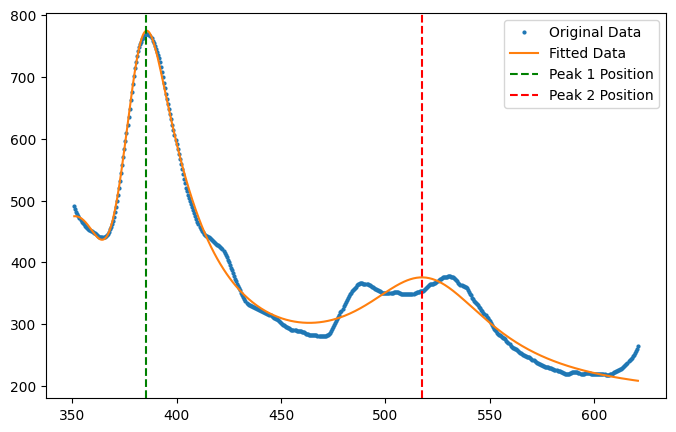

,amplitude,fwhm,peak_positions
peak 1,774.380210,46.500613,385.5
peak 2,375.857667,86.542973,517.5


In [23]:
fit (x,y1)

#sample 2

In [46]:
#x
x=(((pl.iloc[18:563,0:1]).to_numpy()).flatten())


#sample2
y2=(((pl.iloc[18:563,3:4]).to_numpy()).flatten())



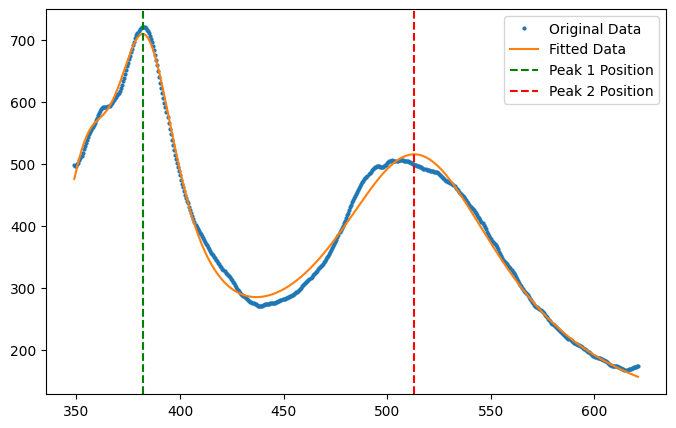

,amplitude,fwhm,peak_positions
peak 1,710.032004,55.205976,382.0
peak 2,515.756301,130.474576,513.0


In [47]:
fit (x , y2)

#sample 3

In [42]:
#x
x=(((pl.iloc[40:563,0:1]).to_numpy()).flatten())

#sample3
y3=(((pl.iloc[40:563,5:6]).to_numpy()).flatten())

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 20000.
  warnings.warn(errors[info][0], RuntimeWarning)


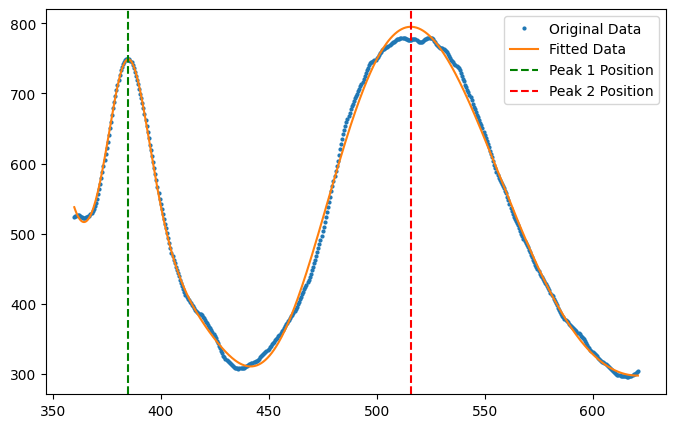

,amplitude,fwhm,peak_positions
peak 1,748.822943,38.368818,385.0
peak 2,795.095620,165.574305,516.0


In [43]:
fit (x , y3)

#sample 4

In [70]:
x=(((pl.iloc[33:563,0:1]).to_numpy()).flatten())
#sample4
y4=(((pl.iloc[33:563,7:8]).to_numpy()).flatten())

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 20000.
  warnings.warn(errors[info][0], RuntimeWarning)


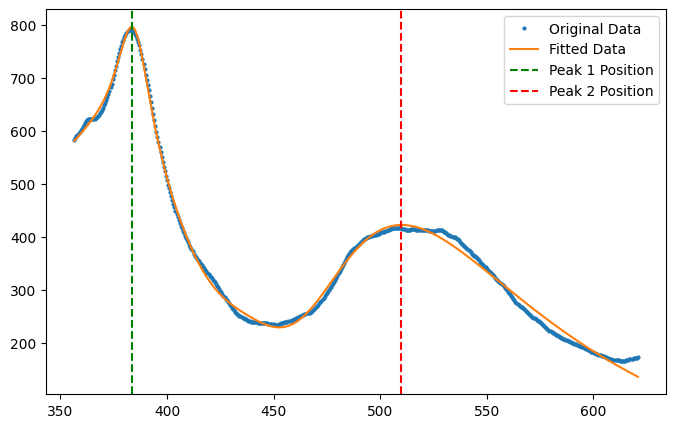

,amplitude,fwhm,peak_positions
peak 1,795.948723,33.941187,383.5
peak 2,422.618404,147.507557,510.0


In [71]:
fit (x , y4)

#sample 5

In [56]:
#x
x=(((pl.iloc[10:563,0:1]).to_numpy()).flatten())

#sample5
y5=(((pl.iloc[10:563,9:10]).to_numpy()).flatten())

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 20000.
  warnings.warn(errors[info][0], RuntimeWarning)


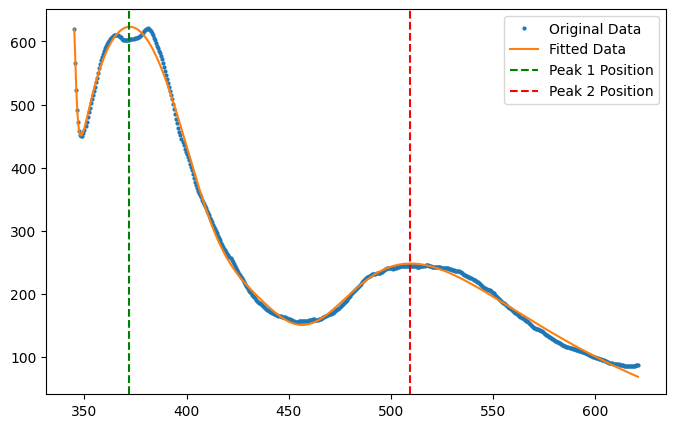

,amplitude,fwhm,peak_positions
peak 1,623.169019,68.677439,372.0
peak 2,248.372152,136.433070,509.5


In [57]:
fit (x,y5)

#bandgap

In [72]:
def calculate_bandgap(wavelength_nm):
    # Constants
    h = 6.626e-34  # Planck's constant in J·s
    c = 3.00e8    # Speed of light in m/s

    # Convert wavelength to meters
    wavelength_m = wavelength_nm * 1e-9

    # Calculate bandgap energy in joules
    bandgap_energy_J = h * c / wavelength_m

    # Convert bandgap energy to electron volts
    bandgap_energy_eV = bandgap_energy_J / (1.602e-19)  # 1 eV = 1.602e-19 J

    return bandgap_energy_eV

# Input wavelengths in nanometers
wavelengths = [385.5, 382, 385.0, 383.5,372.0]

# Calculate bandgap energies for each wavelength
bandgap_energies = [calculate_bandgap(wavelength) for wavelength in wavelengths]

# Create a DataFrame
df = pd.DataFrame({
    'Wavelength (nm)': wavelengths,
    'Bandgap Energy (eV)': bandgap_energies
})

# Print the DataFrame
df

,Wavelength (nm),Bandgap Energy (eV)
0,385.5,3.218739
1,382.0,3.248230
2,385.0,3.222919
3,383.5,3.235525
4,372.0,3.335548
